In [1]:
pip install numpy pandas pyswarms tensorflow scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.7 MB/s eta 0:00:00


In [6]:
import numpy as np
import pandas as pd
import pyswarms as ps
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

data = pd.read_csv('/content/all_data (3).csv')
np.random.seed(42)

In [12]:

def paper_specific_preprocessing(df):

    # Equation 1: Count nulls in each row (w vector)
    w = df.isnull().sum(axis=1)

    # Equation 2: Calculate Median Absolute Deviation (MAD)
    median_w = np.median(w)
    abs_deviation = np.abs(w - median_w)
    mad_w = np.median(abs_deviation)

    # Threshold defined in text: median(w) + 3 * MAD(w)
    threshold = median_w + (3 * mad_w)

    # Filter: Keep rows where null count is less than threshold
    clean_df = df[w <= threshold].copy()

    # Fill remaining small gaps (standard practice for LSTM)
    clean_df.fillna(0, inplace=True)
    print(f"Rows retained: {len(clean_df)} / {len(df)}")
    return clean_df

# Apply the function
data = paper_specific_preprocessing(data)

# Print columns to identify the correct target variable name
print("DataFrame columns:", data.columns)

X_raw = data.drop('class', axis=1)
y = data['class']

# Encode the target variable y (class labels) into numerical values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = pd.Series(le.fit_transform(y), name='class_encoded')
print("Encoded target variable (y) head:")
print(y.head())


[Step 2] Applying MAD-based Preprocessing...
Rows retained: 4998 / 4998
DataFrame columns: Index(['ifInOctets11', 'ifOutOctets11', 'ifoutDiscards11', 'ifInUcastPkts11',
       'ifInNUcastPkts11', 'ifInDiscards11', 'ifOutUcastPkts11',
       'ifOutNUcastPkts11', 'tcpOutRsts', 'tcpInSegs', 'tcpOutSegs',
       'tcpPassiveOpens', 'tcpRetransSegs', 'tcpCurrEstab', 'tcpEstabResets',
       'tcp?ActiveOpens', 'udpInDatagrams', 'udpOutDatagrams', 'udpInErrors',
       'udpNoPorts', 'ipInReceives', 'ipInDelivers', 'ipOutRequests',
       'ipOutDiscards', 'ipInDiscards', 'ipForwDatagrams', 'ipOutNoRoutes',
       'ipInAddrErrors', 'icmpInMsgs', 'icmpInDestUnreachs', 'icmpOutMsgs',
       'icmpOutDestUnreachs', 'icmpInEchos', 'icmpOutEchoReps', 'class'],
      dtype='object')
Encoded target variable (y) head:
0    3
1    3
2    3
3    3
4    3
Name: class_encoded, dtype: int64


In [13]:

# CFS Merit Function (Equation 3)
def get_cfs_merit(subset, X_data, y_data):
    selected_indices = [i for i, val in enumerate(subset) if val == 1]
    if len(selected_indices) == 0: return 1e-10
    X_subset = X_data.iloc[:, selected_indices]
    # Feature-Class Correlation (r_cf)
    r_cf = np.mean([abs(X_subset[col].corr(y_data)) for col in X_subset.columns])

    # Feature-Feature Intercorrelation (r_ff)
    if len(selected_indices) > 1:
        corr_matrix = X_subset.corr().abs()
        r_ff = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack().mean()
        if np.isnan(r_ff): r_ff = 0
    else:
        r_ff = 0

    k = len(selected_indices)
    merit = (k * r_cf) / np.sqrt(k + k * (k - 1) * r_ff + 1e-10)
    return merit
# Objective Function for PSO
def f(x):
    n_particles = x.shape[0]
    j = []
    for i in range(n_particles):
        # Invert merit because PSO minimizes cost (we want to maximize merit)
        score = -get_cfs_merit(x[i], X_raw, y)
        j.append(score)
    return np.array(j)
# Run PSO
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 2, 'p': 1} # Hyperparameters from paper logic, added k and p
optimizer = ps.discrete.BinaryPSO(n_particles=10, dimensions=X_raw.shape[1], options=options)
cost, pos = optimizer.optimize(f, iters=10, verbose=True)
# Select best features
selected_indices = [i for i, val in enumerate(pos) if val == 1]
X_selected = X_raw.iloc[:, selected_indices]
print(f"Selected Features: {list(X_selected.columns)}")

2025-12-07 21:15:25,475 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 2, 'p': 1}



[Step 3] Running PSO for Feature Selection...


pyswarms.discrete.binary: 100%|██████████|10/10, best_cost=-0.418
2025-12-07 21:15:27,361 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: -0.4177594411953403, best pos: [0 0 0 0 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0]


Selected Features: ['ifInNUcastPkts11', 'ifInDiscards11', 'tcpOutRsts', 'tcpInSegs', 'tcpOutSegs', 'tcpEstabResets', 'tcp?ActiveOpens', 'udpInDatagrams', 'udpInErrors', 'udpNoPorts', 'ipInDiscards', 'ipForwDatagrams', 'ipOutNoRoutes', 'icmpInMsgs', 'icmpInEchos']


In [14]:
# 1. Normalize and Reshape
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_selected)
# Reshape to [samples, time_steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# 2. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)
# Flatten for KNN
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# 3. Train LSTM
start_train = time.time()
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# 4. Generate Initial Predictions (J_LSTM)
lstm_train_pred = lstm_model.predict(X_train).flatten()
lstm_test_pred = lstm_model.predict(X_test).flatten()

# 5. Train KNN on Errors (Equation 6)
train_errors = y_train - lstm_train_pred # Residuals
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(X_train_flat, train_errors)
end_train = time.time()

# 6. Correct Predictions (Equation 8)
predicted_test_errors = knn.predict(X_test_flat)
final_predictions = lstm_test_pred + predicted_test_errors

# Convert to Class Labels (0 or 1)
y_pred_binary = [1 if val > 0.5 else 0 for val in final_predictions]
print("Training Complete.")


[Step 4] Training Hybrid LSTM-KNN Model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training Complete.



[Step 5] Generating Results and Plots...


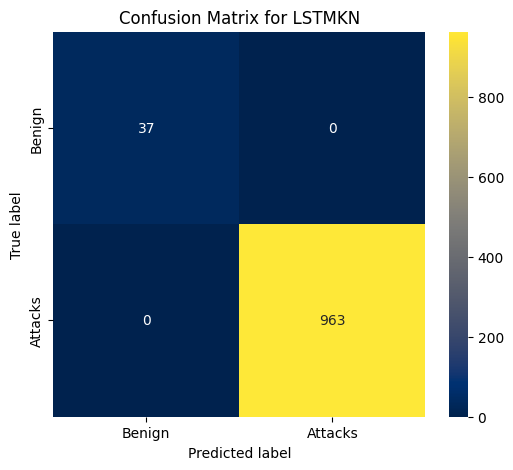

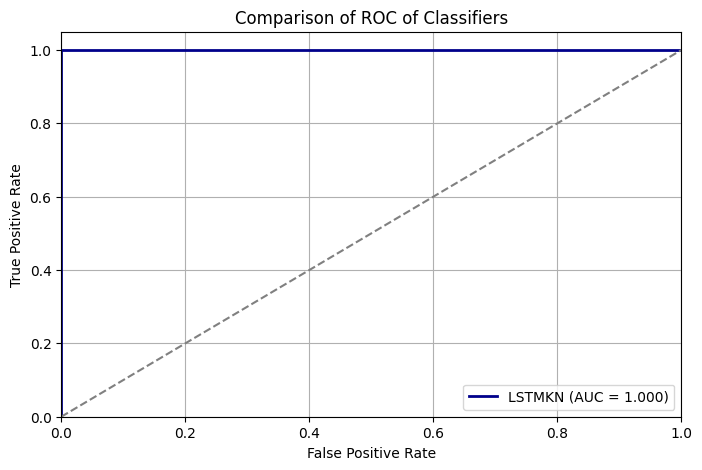

Total Training Time: 8.9536 seconds

Final Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00        37
     Attacks       1.00      1.00      1.00       963

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [16]:
y_test_binary = (y_test != 0).astype(int)

# 1. Confusion Matrix (Figure 3)
cm = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='cividis', xticklabels=['Benign', 'Attacks'], yticklabels=['Benign', 'Attacks'])
plt.title('Confusion Matrix for LSTMKN')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# 2. ROC Curve (Figure 4)
fpr, tpr, thresholds = roc_curve(y_test_binary, final_predictions)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'LSTMKN (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC of Classifiers')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 3. Training Time (Figure 5)
train_time = end_train - start_train
print(f"Total Training Time: {train_time:.4f} seconds")

# 4. Metrics Table (Table 1 & Figure 6)
acc = accuracy_score(y_test_binary, y_pred_binary) * 100
print(f"\nFinal Accuracy: {acc:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary, target_names=['Benign', 'Attacks']))

In [17]:
# 1. Initialize and fit MinMaxScaler to X_selected, then transform it.
scaler_cv = MinMaxScaler()
X_scaled_cv = scaler_cv.fit_transform(X_selected)

# 2. Reset the index of y to align with X_selected
y = y.reset_index(drop=True)

print("X_scaled_cv shape:", X_scaled_cv.shape)
print("y shape after index reset:", y.shape)
print("Data preparation for cross-validation complete.")


[Step 5.1] Preparing data for Cross-Validation...
X_scaled_cv shape: (4998, 15)
y shape after index reset: (4998,)
Data preparation for cross-validation complete.


In [18]:
from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

all_y_true = []
all_y_pred = []
fold_training_times = []

for fold, (train_index, test_index) in enumerate(kf.split(X_scaled_cv)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    X_train_fold, X_test_fold = X_scaled_cv[train_index], X_scaled_cv[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Reshape for LSTM: [samples, time_steps, features]
    X_train_lstm = X_train_fold.reshape(
        (X_train_fold.shape[0], 1, X_train_fold.shape[1])
    )
    X_test_lstm = X_test_fold.reshape(
        (X_test_fold.shape[0], 1, X_test_fold.shape[1])
    )

    # Flatten for KNN (original scaled features)
    X_train_knn = X_train_fold
    X_test_knn = X_test_fold

    start_fold_time = time.time()

    # 1. Train LSTM
    lstm_model_fold = Sequential()
    lstm_model_fold.add(LSTM(50, activation='relu', input_shape=(1, X_train_lstm.shape[2])))
    lstm_model_fold.add(Dense(1))
    lstm_model_fold.compile(optimizer='adam', loss='mse')
    lstm_model_fold.fit(X_train_lstm, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # 2. Generate Initial LSTM Predictions
    lstm_train_pred_fold = lstm_model_fold.predict(X_train_lstm).flatten()
    lstm_test_pred_fold = lstm_model_fold.predict(X_test_lstm).flatten()

    # 3. Train KNN on Errors (Equation 6)
    train_errors_fold = y_train_fold - lstm_train_pred_fold  # Residuals
    knn_fold = KNeighborsRegressor(n_neighbors=5, weights='distance')
    knn_fold.fit(X_train_knn, train_errors_fold)

    # 4. Correct Predictions (Equation 8)
    predicted_test_errors_fold = knn_fold.predict(X_test_knn)
    final_predictions_fold = lstm_test_pred_fold + predicted_test_errors_fold

    end_fold_time = time.time()
    fold_training_times.append(end_fold_time - start_fold_time)

    # Convert to Class Labels (0 or 1)
    y_pred_binary_fold = [1 if val > 0.5 else 0 for val in final_predictions_fold]
    y_test_binary_fold = (y_test_fold != 0).astype(int) # Binarize true labels

    all_y_true.extend(y_test_binary_fold)
    all_y_pred.extend(y_pred_binary_fold)

print("Cross-validation complete. Aggregating results...")



[Step 5.2] Performing 5-Fold Cross-Validation for LSTM-KNN Model...

--- Fold 1/5 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

--- Fold 2/5 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

--- Fold 3/5 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

--- Fold 4/5 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

--- Fold 5/5 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Cross-validation complete. Aggregating results...


[Step 5.3] Aggregating Cross-Validation Results...

Average Training Time per Fold: 7.3289 seconds


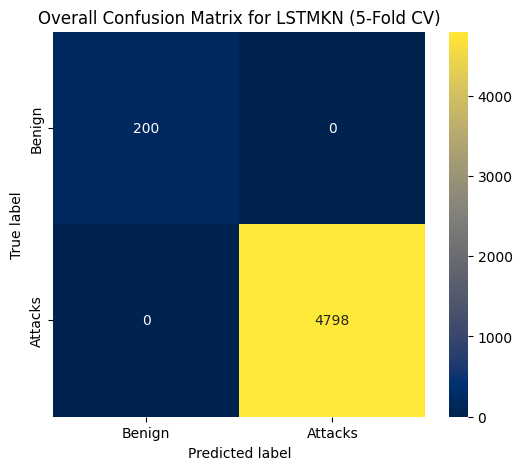

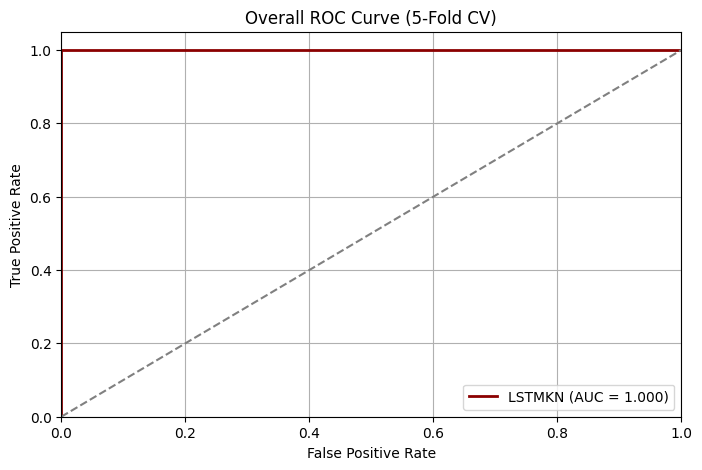


Overall Accuracy (5-Fold CV): 100.00%

Overall Classification Report (5-Fold CV):
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       200
     Attacks       1.00      1.00      1.00      4798

    accuracy                           1.00      4998
   macro avg       1.00      1.00      1.00      4998
weighted avg       1.00      1.00      1.00      4998



In [21]:
print("[Step 5.3] Aggregating Cross-Validation Results...")

# 1. Average Training Time
if fold_training_times:
    avg_training_time_cv = np.mean(fold_training_times)
    print(f"\nAverage Training Time per Fold: {avg_training_time_cv:.4f} seconds")
else:
    print("No training times recorded.")

# Convert lists to numpy arrays for metrics calculation
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# 2. Overall Confusion Matrix
overall_cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='cividis',
            xticklabels=['Benign', 'Attacks'], yticklabels=['Benign', 'Attacks'])
plt.title('Overall Confusion Matrix for LSTMKN (5-Fold CV)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

fpr_cv, tpr_cv, thresholds_cv = roc_curve(all_y_true, all_y_pred)
roc_auc_cv = auc(fpr_cv, tpr_cv)

plt.figure(figsize=(8, 5))
plt.plot(fpr_cv, tpr_cv, color='darkred', lw=2, label=f'LSTMKN (AUC = {roc_auc_cv:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall ROC Curve (5-Fold CV)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 4. Overall Metrics (Accuracy, Classification Report)
overall_acc = accuracy_score(all_y_true, all_y_pred) * 100
print(f"\nOverall Accuracy (5-Fold CV): {overall_acc:.2f}%")
print("\nOverall Classification Report (5-Fold CV):")
print(classification_report(all_y_true, all_y_pred, target_names=['Benign', 'Attacks']))

In [29]:
from tensorflow.keras.layers import SimpleRNN # Added import for SimpleRNN

n_splits_rnn = 5
kf_rnn = KFold(n_splits=n_splits_rnn, shuffle=True, random_state=42)

all_y_true_rnn = []
all_y_pred_raw_rnn = []
fold_training_times_rnn = []

for fold, (train_index, test_index) in enumerate(kf_rnn.split(X_scaled_cv)):
    print(f"\n--- Fold {fold+1}/{n_splits_rnn} (RNN) ---")

    X_train_fold, X_test_fold = X_scaled_cv[train_index], X_scaled_cv[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Reshape for RNN: [samples, time_steps, features]
    X_train_rnn = X_train_fold.reshape(
        (X_train_fold.shape[0], 1, X_train_fold.shape[1])
    )
    X_test_rnn = X_test_fold.reshape(
        (X_test_fold.shape[0], 1, X_test_fold.shape[1])
    )

    start_fold_time_rnn = time.time()

    # Define and train RNN model
    rnn_model = Sequential()
    rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(1, X_train_rnn.shape[2])))
    rnn_model.add(Dense(1))
    rnn_model.compile(optimizer='adam', loss='mse')
    rnn_model.fit(X_train_rnn, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Generate raw predictions
    raw_predictions_fold_rnn = rnn_model.predict(X_test_rnn).flatten()

    end_fold_time_rnn = time.time()
    fold_training_times_rnn.append(end_fold_time_rnn - start_fold_time_rnn)

    # Binarize true labels for evaluation (0 for 'Benign', 1 for 'Attacks')
    y_test_binary_fold_rnn = (y_test_fold != 0).astype(int)

    all_y_true_rnn.extend(y_test_binary_fold_rnn)
    all_y_pred_raw_rnn.extend(raw_predictions_fold_rnn)

print("RNN Cross-validation complete. Aggregating results...")


[Step 5.4] Performing 5-Fold Cross-Validation for RNN Model...

--- Fold 1/5 (RNN) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

--- Fold 2/5 (RNN) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

--- Fold 3/5 (RNN) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

--- Fold 4/5 (RNN) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

--- Fold 5/5 (RNN) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RNN Cross-validation complete. Aggregating results...


In [23]:
from tensorflow.keras.layers import SimpleRNN # Added import for SimpleRNN

n_splits_rnn = 5
kf_rnn = KFold(n_splits=n_splits_rnn, shuffle=True, random_state=42)

all_y_true_rnn = []
all_y_pred_raw_rnn = []
fold_training_times_rnn = []

for fold, (train_index, test_index) in enumerate(kf_rnn.split(X_scaled_cv)):
    print(f"\n--- Fold {fold+1}/{n_splits_rnn} (RNN) ---")

    X_train_fold, X_test_fold = X_scaled_cv[train_index], X_scaled_cv[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Reshape for RNN: [samples, time_steps, features]
    X_train_rnn = X_train_fold.reshape(
        (X_train_fold.shape[0], 1, X_train_fold.shape[1])
    )
    X_test_rnn = X_test_fold.reshape(
        (X_test_fold.shape[0], 1, X_test_fold.shape[1])
    )

    start_fold_time_rnn = time.time()

    # Define and train RNN model
    rnn_model = Sequential()
    rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(1, X_train_rnn.shape[2])))
    rnn_model.add(Dense(1))
    rnn_model.compile(optimizer='adam', loss='mse')
    rnn_model.fit(X_train_rnn, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Generate raw predictions
    raw_predictions_fold_rnn = rnn_model.predict(X_test_rnn).flatten()

    end_fold_time_rnn = time.time()
    fold_training_times_rnn.append(end_fold_time_rnn - start_fold_time_rnn)

    # Binarize true labels for evaluation (0 for 'Benign', 1 for 'Attacks')
    y_test_binary_fold_rnn = (y_test_fold != 0).astype(int)

    all_y_true_rnn.extend(y_test_binary_fold_rnn)
    all_y_pred_raw_rnn.extend(raw_predictions_fold_rnn)

print("RNN Cross-validation complete. Aggregating results...")


[Step 5.4] Performing 5-Fold Cross-Validation for RNN Model...

--- Fold 1/5 (RNN) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

--- Fold 2/5 (RNN) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

--- Fold 3/5 (RNN) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

--- Fold 4/5 (RNN) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

--- Fold 5/5 (RNN) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RNN Cross-validation complete. Aggregating results...


[Step 5.5] Aggregating RNN Cross-Validation Results...

Average Training Time per Fold (RNN): 5.9170 seconds


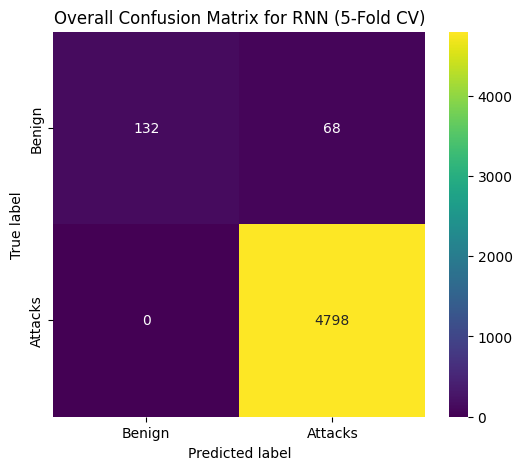

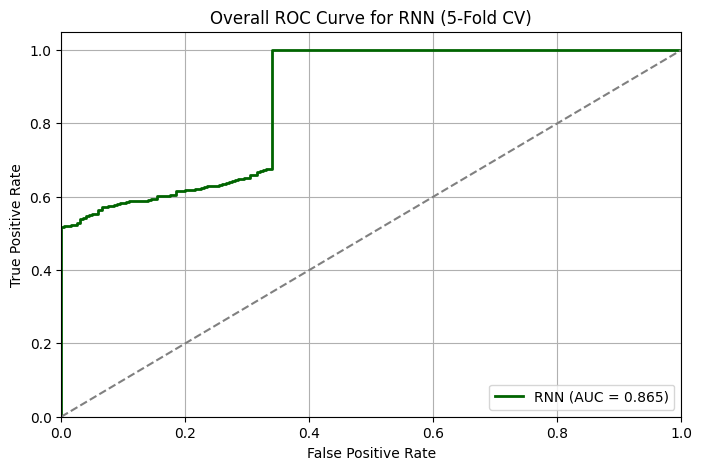


Overall Accuracy (5-Fold CV, RNN): 98.64%

Overall Classification Report (5-Fold CV, RNN):
              precision    recall  f1-score   support

      Benign       1.00      0.66      0.80       200
     Attacks       0.99      1.00      0.99      4798

    accuracy                           0.99      4998
   macro avg       0.99      0.83      0.89      4998
weighted avg       0.99      0.99      0.99      4998



In [24]:
# 1. Average Training Time
if fold_training_times_rnn:
    avg_training_time_rnn = np.mean(fold_training_times_rnn)
    print(f"\nAverage Training Time per Fold (RNN): {avg_training_time_rnn:.4f} seconds")
else:
    print("No RNN training times recorded.")

# Convert lists to numpy arrays for metrics calculation
all_y_true_rnn = np.array(all_y_true_rnn)
all_y_pred_raw_rnn = np.array(all_y_pred_raw_rnn)

# Binarize raw predictions for classification metrics (0 or 1)
all_y_pred_binary_rnn = (all_y_pred_raw_rnn > 0.5).astype(int)

# 2. Overall Confusion Matrix (RNN)
overall_cm_rnn = confusion_matrix(all_y_true_rnn, all_y_pred_binary_rnn)
plt.figure(figsize=(6, 5))
sns.heatmap(overall_cm_rnn, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Benign', 'Attacks'], yticklabels=['Benign', 'Attacks'])
plt.title('Overall Confusion Matrix for RNN (5-Fold CV)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# 3. Overall ROC Curve (RNN)
fpr_rnn, tpr_rnn, thresholds_rnn = roc_curve(all_y_true_rnn, all_y_pred_raw_rnn)
roc_auc_rnn = auc(fpr_rnn, tpr_rnn)

plt.figure(figsize=(8, 5))
plt.plot(fpr_rnn, tpr_rnn, color='darkgreen', lw=2, label=f'RNN (AUC = {roc_auc_rnn:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall ROC Curve for RNN (5-Fold CV)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 4. Overall Metrics (Accuracy, Classification Report for RNN)
overall_acc_rnn = accuracy_score(all_y_true_rnn, all_y_pred_binary_rnn) * 100
print(f"\nOverall Accuracy (5-Fold CV, RNN): {overall_acc_rnn:.2f}%")
print("\nOverall Classification Report (5-Fold CV, RNN):")
print(classification_report(all_y_true_rnn, all_y_pred_binary_rnn, target_names=['Benign', 'Attacks']))


In [25]:
from tensorflow.keras.layers import Bidirectional # Added import for Bidirectional

n_splits_bilstm = 5
kf_bilstm = KFold(n_splits=n_splits_bilstm, shuffle=True, random_state=42)

all_y_true_bilstm = []
all_y_pred_raw_bilstm = []
fold_training_times_bilstm = []

for fold, (train_index, test_index) in enumerate(kf_bilstm.split(X_scaled_cv)):
    print(f"\n--- Fold {fold+1}/{n_splits_bilstm} (Bi-LSTM) ---")

    X_train_fold, X_test_fold = X_scaled_cv[train_index], X_scaled_cv[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Reshape for Bi-LSTM: [samples, time_steps, features]
    X_train_bilstm = X_train_fold.reshape(
        (X_train_fold.shape[0], 1, X_train_fold.shape[1])
    )
    X_test_bilstm = X_test_fold.reshape(
        (X_test_fold.shape[0], 1, X_test_fold.shape[1])
    )

    start_fold_time_bilstm = time.time()

    # Define and train Bi-LSTM model
    bilstm_model = Sequential()
    bilstm_model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(1, X_train_bilstm.shape[2])))
    bilstm_model.add(Dense(1))
    bilstm_model.compile(optimizer='adam', loss='mse')
    bilstm_model.fit(X_train_bilstm, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Generate raw predictions
    raw_predictions_fold_bilstm = bilstm_model.predict(X_test_bilstm).flatten()

    end_fold_time_bilstm = time.time()
    fold_training_times_bilstm.append(end_fold_time_bilstm - start_fold_time_bilstm)

    # Binarize true labels for evaluation (0 for 'Benign', 1 for 'Attacks')
    y_test_binary_fold_bilstm = (y_test_fold != 0).astype(int)

    all_y_true_bilstm.extend(y_test_binary_fold_bilstm)
    all_y_pred_raw_bilstm.extend(raw_predictions_fold_bilstm)

print("Bi-LSTM Cross-validation complete. Aggregating results...")


[Step 5.6] Performing 5-Fold Cross-Validation for Bi-LSTM Model...

--- Fold 1/5 (Bi-LSTM) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

--- Fold 2/5 (Bi-LSTM) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

--- Fold 3/5 (Bi-LSTM) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

--- Fold 4/5 (Bi-LSTM) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

--- Fold 5/5 (Bi-LSTM) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Bi-LSTM Cross-validation complete. Aggregating results...


**Reasoning**:
Now that the 5-fold cross-validation for the Bi-LSTM model is complete and raw predictions and true labels have been aggregated, I will calculate and display the overall performance metrics, including the average training time, confusion matrix, ROC curve, and classification report, to fully evaluate the Bi-LSTM model's performance.



[Step 5.7] Aggregating Bi-LSTM Cross-Validation Results...

Average Training Time per Fold (Bi-LSTM): 11.0811 seconds


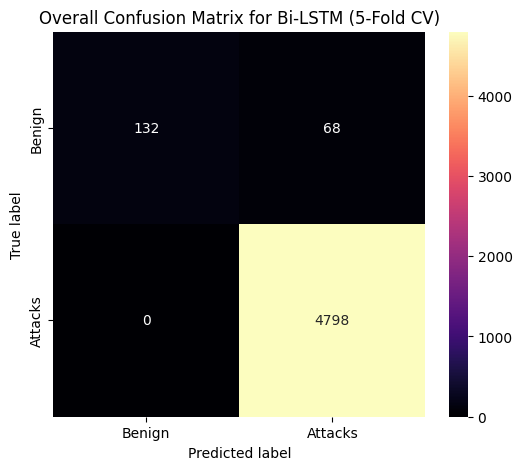

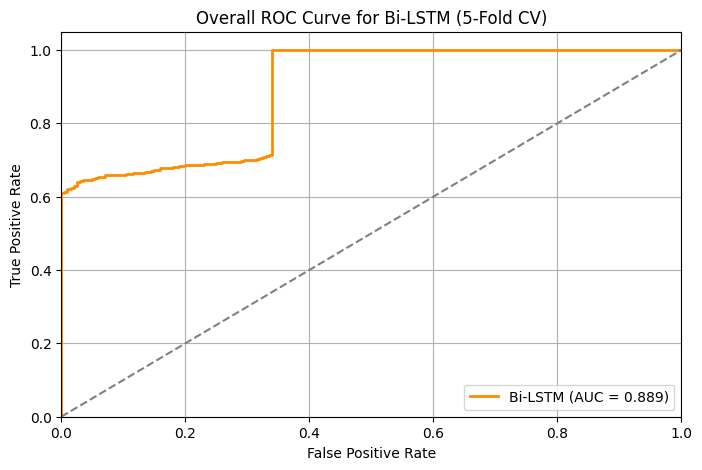


Overall Accuracy (5-Fold CV, Bi-LSTM): 98.64%

Overall Classification Report (5-Fold CV, Bi-LSTM):
              precision    recall  f1-score   support

      Benign       1.00      0.66      0.80       200
     Attacks       0.99      1.00      0.99      4798

    accuracy                           0.99      4998
   macro avg       0.99      0.83      0.89      4998
weighted avg       0.99      0.99      0.99      4998



In [26]:
# 1. Average Training Time
if fold_training_times_bilstm:
    avg_training_time_bilstm = np.mean(fold_training_times_bilstm)
    print(f"\nAverage Training Time per Fold (Bi-LSTM): {avg_training_time_bilstm:.4f} seconds")
else:
    print("No Bi-LSTM training times recorded.")

# Convert lists to numpy arrays for metrics calculation
all_y_true_bilstm = np.array(all_y_true_bilstm)
all_y_pred_raw_bilstm = np.array(all_y_pred_raw_bilstm)

# Binarize raw predictions for classification metrics (0 or 1)
all_y_pred_binary_bilstm = (all_y_pred_raw_bilstm > 0.5).astype(int)

# 2. Overall Confusion Matrix (Bi-LSTM)
overall_cm_bilstm = confusion_matrix(all_y_true_bilstm, all_y_pred_binary_bilstm)
plt.figure(figsize=(6, 5))
sns.heatmap(overall_cm_bilstm, annot=True, fmt='d', cmap='magma',
            xticklabels=['Benign', 'Attacks'], yticklabels=['Benign', 'Attacks'])
plt.title('Overall Confusion Matrix for Bi-LSTM (5-Fold CV)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# 3. Overall ROC Curve (Bi-LSTM)
fpr_bilstm, tpr_bilstm, thresholds_bilstm = roc_curve(all_y_true_bilstm, all_y_pred_raw_bilstm)
roc_auc_bilstm = auc(fpr_bilstm, tpr_bilstm)

plt.figure(figsize=(8, 5))
plt.plot(fpr_bilstm, tpr_bilstm, color='darkorange', lw=2, label=f'Bi-LSTM (AUC = {roc_auc_bilstm:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall ROC Curve for Bi-LSTM (5-Fold CV)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 4. Overall Metrics (Accuracy, Classification Report for Bi-LSTM)
overall_acc_bilstm = accuracy_score(all_y_true_bilstm, all_y_pred_binary_bilstm) * 100
print(f"\nOverall Accuracy (5-Fold CV, Bi-LSTM): {overall_acc_bilstm:.2f}%")
print("\nOverall Classification Report (5-Fold CV, Bi-LSTM):")
print(classification_report(all_y_true_bilstm, all_y_pred_binary_bilstm, target_names=['Benign', 'Attacks']))


[Step 5.8] Aggregating and Comparing All Model Results...

--- Model Performance Summary ---
| Model    |   Accuracy |    AUC |   Benign_Precision |   Benign_Recall |   Benign_F1-Score |   Attacks_Precision |   Attacks_Recall |   Attacks_F1-Score |   Avg_Training_Time |
|:---------|-----------:|-------:|-------------------:|----------------:|------------------:|--------------------:|-----------------:|-------------------:|--------------------:|
| LSTM-KNN |   100      | 1      |                  1 |            1    |            1      |               1     |                1 |              1     |              7.3289 |
| RNN      |    98.6395 | 0.8646 |                  1 |            0.66 |            0.7952 |               0.986 |                1 |              0.993 |              5.917  |
| Bi-LSTM  |    98.6395 | 0.8888 |                  1 |            0.66 |            0.7952 |               0.986 |                1 |              0.993 |             11.0811 |


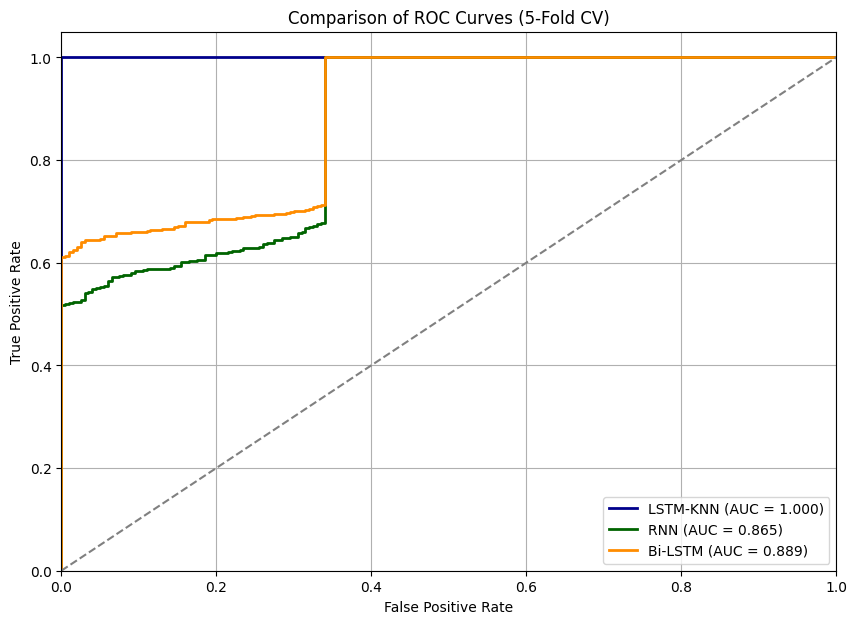

/tmp/ipython-input-2119477443.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=summary_df, palette='viridis')


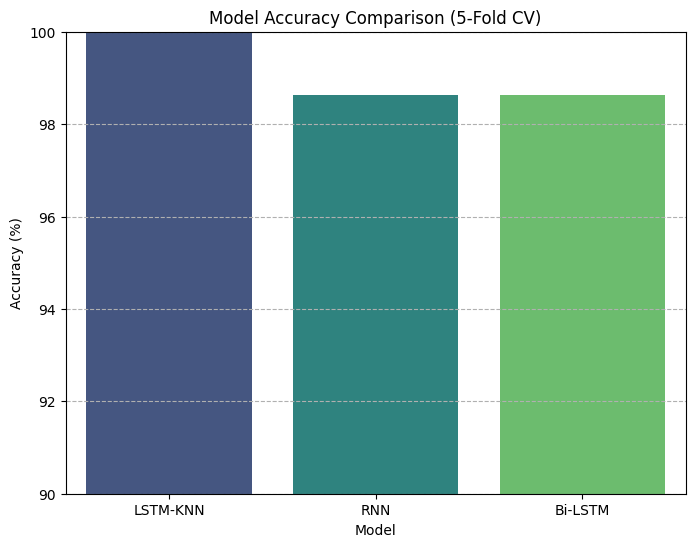

In [73]:
print("[Step 5.8] Aggregating and Comparing All Model Results...")

report_lstmkn = classification_report(all_y_true, all_y_pred, target_names=['Benign', 'Attacks'], output_dict=True)
acc_lstmkn = accuracy_score(all_y_true, all_y_pred) * 100

report_rnn = classification_report(all_y_true_rnn, all_y_pred_binary_rnn, target_names=['Benign', 'Attacks'], output_dict=True)
acc_rnn = accuracy_score(all_y_true_rnn, all_y_pred_binary_rnn) * 100

report_bilstm = classification_report(all_y_true_bilstm, all_y_pred_binary_bilstm, target_names=['Benign', 'Attacks'], output_dict=True)
acc_bilstm = accuracy_score(all_y_true_bilstm, all_y_pred_binary_bilstm) * 100

# Prepare data for summary DataFrame
metrics_data = {
    'Model': ['LSTM-KNN', 'RNN', 'Bi-LSTM'],
    'Accuracy': [acc_lstmkn, acc_rnn, acc_bilstm],
    'AUC': [roc_auc_cv, roc_auc_rnn, roc_auc_bilstm],
    'Benign_Precision': [report_lstmkn['Benign']['precision'], report_rnn['Benign']['precision'], report_bilstm['Benign']['precision']],
    'Benign_Recall': [report_lstmkn['Benign']['recall'], report_rnn['Benign']['recall'], report_bilstm['Benign']['recall']],
    'Benign_F1-Score': [report_lstmkn['Benign']['f1-score'], report_rnn['Benign']['f1-score'], report_bilstm['Benign']['f1-score']],
    'Attacks_Precision': [report_lstmkn['Attacks']['precision'], report_rnn['Attacks']['precision'], report_bilstm['Attacks']['precision']],
    'Attacks_Recall': [report_lstmkn['Attacks']['recall'], report_rnn['Attacks']['recall'], report_bilstm['Attacks']['recall']],
    'Attacks_F1-Score': [report_lstmkn['Attacks']['f1-score'], report_rnn['Attacks']['f1-score'], report_bilstm['Attacks']['f1-score']],
    'Avg_Training_Time': [avg_training_time_cv, avg_training_time_rnn, avg_training_time_bilstm]
}

summary_df = pd.DataFrame(metrics_data)
print(summary_df.round(4).to_markdown(index=False))

#Combined ROC Curve Plot
plt.figure(figsize=(10, 7))
plt.plot(fpr_cv, tpr_cv, color='darkblue', lw=2, label=f'LSTM-KNN (AUC = {roc_auc_cv:.3f})')
plt.plot(fpr_rnn, tpr_rnn, color='darkgreen', lw=2, label=f'RNN (AUC = {roc_auc_rnn:.3f})')
plt.plot(fpr_bilstm, tpr_bilstm, color='darkorange', lw=2, label=f'Bi-LSTM (AUC = {roc_auc_bilstm:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves (5-Fold CV)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#Accuracy Comparison Bar Chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=summary_df, palette='viridis')
plt.ylim(90, 100) # Assuming accuracies are high
plt.title('Model Accuracy Comparison (5-Fold CV)')
plt.ylabel('Accuracy (%)')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--')
plt.show()


[Step 8] Visualizing Feature Distributions for 'Benign' vs. 'Attacks'...


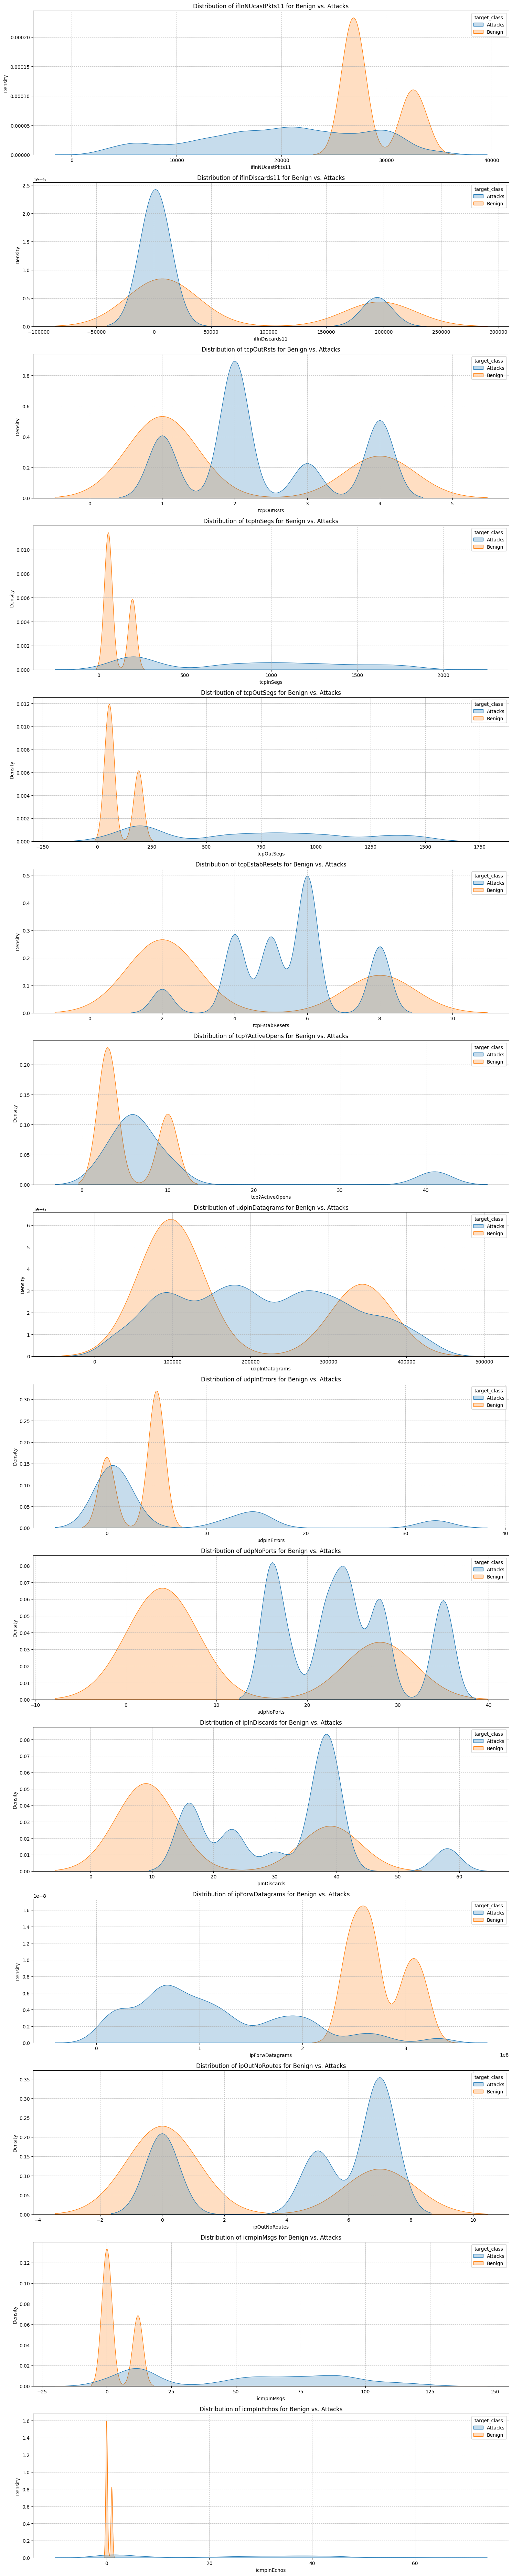

Feature distribution visualization complete.


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

y_full_binary = (y != 0).astype(int)

# Combine selected features with the binarized target for plotting
plot_df = X_selected.copy()
plot_df['target_class'] = y_full_binary.map({0: 'Benign', 1: 'Attacks'})

# Get the list of selected features
selected_feature_columns = X_selected.columns

# Plot distributions for each selected feature
plt.figure(figsize=(15, 5 * len(selected_feature_columns)))
for i, feature in enumerate(selected_feature_columns):
    plt.subplot(len(selected_feature_columns), 1, i + 1)
    sns.kdeplot(data=plot_df, x=feature, hue='target_class', fill=True, common_norm=False)
    plt.title(f'Distribution of {feature} for Benign vs. Attacks')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Feature distribution visualization complete.")

In [38]:
print("[Step 6.1] Analyzing class distribution of target variable `y`...")

# Calculate and print value counts for the original target variable `y`
class_counts = y.value_counts()
print("\nClass Value Counts in y:\n", class_counts)

# Calculate and print the percentage distribution of each class in `y`
class_percentages = y.value_counts(normalize=True) * 100
print("\nClass Percentage Distribution in y:\n", class_percentages.round(2))

# Binarize `y` for later use in stratified splitting (if not already done)
y_binary_stratified = (y != 0).astype(int)
print("\nBinarized target variable (y_binary_stratified) head:\n", y_binary_stratified.head())
print("Class distribution analysis complete.")

[Step 6.1] Analyzing class distribution of target variable `y`...

Class Value Counts in y:
 class_encoded
6    960
4    780
7    773
2    632
3    600
1    573
5    480
0    200
Name: count, dtype: int64

Class Percentage Distribution in y:
 class_encoded
6    19.21
4    15.61
7    15.47
2    12.65
3    12.00
1    11.46
5     9.60
0     4.00
Name: proportion, dtype: float64

Binarized target variable (y_binary_stratified) head:
 0    1
1    1
2    1
3    1
4    1
Name: class_encoded, dtype: int64
Class distribution analysis complete.


In [61]:
import numpy as np
import pandas as pd
import pyswarms as ps
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

data = pd.read_csv('/content/all_data (3).csv')
np.random.seed(42)

In [64]:
print("[Step 6.3] Performing 5-Fold Stratified Cross-Validation for All Models...")

from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import SimpleRNN, Bidirectional

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Storage for all models' results ---
# Hybrid LSTM-KNN
all_y_true_lstmkn_strat = []
all_y_pred_raw_lstmkn_strat = [] # Raw predictions for AUC
fold_training_times_lstmkn_strat = []

# Standalone LSTM
all_y_true_lstm_strat = []
all_y_pred_raw_lstm_strat = []
fold_training_times_lstm_strat = []

# Standalone RNN
all_y_true_rnn_strat = []
all_y_pred_raw_rnn_strat = []
fold_training_times_rnn_strat = []

# Standalone Bi-LSTM
all_y_true_bilstm_strat = []
all_y_pred_raw_bilstm_strat = []
fold_training_times_bilstm_strat = []

# Standalone KNN
all_y_true_knn_strat = []
all_y_pred_raw_knn_strat = [] # Store actual values for KNN (might not be 'raw' in the same sense as NN scores)
fold_training_times_knn_strat = []

# Assuming X_scaled_cv, y_binary_stratified and class_weight_dict are available from previous steps

for fold, (train_index, test_index) in enumerate(kf.split(X_scaled_cv, y_binary_stratified)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    X_train_fold, X_test_fold = X_scaled_cv[train_index], X_scaled_cv[test_index]
    y_train_fold_original, y_test_fold_original = y.iloc[train_index], y.iloc[test_index]

    # Binarize true labels for current fold (for consistent evaluation)
    y_train_fold_binary = (y_train_fold_original != 0).astype(int)
    y_test_fold_binary = (y_test_fold_original != 0).astype(int)

    # Reshape for LSTM/RNN/Bi-LSTM: [samples, time_steps, features]
    X_train_reshaped = X_train_fold.reshape((X_train_fold.shape[0], 1, X_train_fold.shape[1]))
    X_test_reshaped = X_test_fold.reshape((X_test_fold.shape[0], 1, X_test_fold.shape[1]))

    # 1. Hybrid LSTM-KNN Model
    start_time_lstmkn = time.time()
    # Train LSTM part
    lstm_model_hybrid = Sequential()
    lstm_model_hybrid.add(LSTM(50, activation='relu', input_shape=(1, X_train_reshaped.shape[2])))
    lstm_model_hybrid.add(Dense(1))
    lstm_model_hybrid.compile(optimizer='adam', loss='mse')
    # Use class_weight_dict for LSTM training
    lstm_model_hybrid.fit(X_train_reshaped, y_train_fold_binary, epochs=10, batch_size=32, verbose=0, class_weight=class_weight_dict)

    # Generate initial predictions
    lstm_train_pred_hybrid = lstm_model_hybrid.predict(X_train_reshaped).flatten()
    lstm_test_pred_hybrid = lstm_model_hybrid.predict(X_test_reshaped).flatten()

    # Train KNN on errors
    train_errors_hybrid = y_train_fold_binary - lstm_train_pred_hybrid # Residuals
    knn_hybrid = KNeighborsRegressor(n_neighbors=5, weights='distance')
    knn_hybrid.fit(X_train_fold, train_errors_hybrid)

    # Correct predictions
    predicted_test_errors_hybrid = knn_hybrid.predict(X_test_fold)
    final_predictions_lstmkn = lstm_test_pred_hybrid + predicted_test_errors_hybrid

    end_time_lstmkn = time.time()
    fold_training_times_lstmkn_strat.append(end_time_lstmkn - start_time_lstmkn)

    all_y_true_lstmkn_strat.extend(y_test_fold_binary)
    all_y_pred_raw_lstmkn_strat.extend(final_predictions_lstmkn)

    # --2. Standalone LSTM Model
    start_time_lstm = time.time()
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, activation='relu', input_shape=(1, X_train_reshaped.shape[2])))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_train_reshaped, y_train_fold_binary, epochs=10, batch_size=32, verbose=0, class_weight=class_weight_dict)
    raw_predictions_lstm = lstm_model.predict(X_test_reshaped).flatten()
    end_time_lstm = time.time()
    fold_training_times_lstm_strat.append(end_time_lstm - start_time_lstm)
    all_y_true_lstm_strat.extend(y_test_fold_binary)
    all_y_pred_raw_lstm_strat.extend(raw_predictions_lstm)

    # --- 3. Standalone RNN Model ---
    start_time_rnn = time.time()
    rnn_model = Sequential()
    rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(1, X_train_reshaped.shape[2])))
    rnn_model.add(Dense(1))
    rnn_model.compile(optimizer='adam', loss='mse')
    rnn_model.fit(X_train_reshaped, y_train_fold_binary, epochs=10, batch_size=32, verbose=0, class_weight=class_weight_dict)
    raw_predictions_rnn = rnn_model.predict(X_test_reshaped).flatten()
    end_time_rnn = time.time()
    fold_training_times_rnn_strat.append(end_time_rnn - start_time_rnn)
    all_y_true_rnn_strat.extend(y_test_fold_binary)
    all_y_pred_raw_rnn_strat.extend(raw_predictions_rnn)

    # --- 4. Standalone Bi-LSTM Model ---
    start_time_bilstm = time.time()
    bilstm_model = Sequential()
    bilstm_model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(1, X_train_reshaped.shape[2])))
    bilstm_model.add(Dense(1))
    bilstm_model.compile(optimizer='adam', loss='mse')
    bilstm_model.fit(X_train_reshaped, y_train_fold_binary, epochs=10, batch_size=32, verbose=0, class_weight=class_weight_dict)
    raw_predictions_bilstm = bilstm_model.predict(X_test_reshaped).flatten()
    end_time_bilstm = time.time()
    fold_training_times_bilstm_strat.append(end_time_bilstm - start_time_bilstm)
    all_y_true_bilstm_strat.extend(y_test_fold_binary)
    all_y_pred_raw_bilstm_strat.extend(raw_predictions_bilstm)

    # --- 5. Standalone KNN Model ---
    start_time_knn = time.time()
    knn_model = KNeighborsRegressor(n_neighbors=5, weights='distance') # KNN is a regressor, not classifier
    knn_model.fit(X_train_fold, y_train_fold_binary) # Train on binarized labels
    raw_predictions_knn = knn_model.predict(X_test_fold).flatten()
    end_time_knn = time.time()
    fold_training_times_knn_strat.append(end_time_knn - start_time_knn)
    all_y_true_knn_strat.extend(y_test_fold_binary)
    all_y_pred_raw_knn_strat.extend(raw_predictions_knn)

print("Stratified K-Fold cross-validation complete for all models.")

[Step 6.3] Performing 5-Fold Stratified Cross-Validation for All Models...

--- Fold 1/5 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

--- Fold 2/5 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

--- Fold 3/5 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

--- Fold 4/5 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

--- Fold 5/5 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Stratified K-Fold cross-validation complete for all models.


**Reasoning**:
The previous code produced Keras UserWarnings about `input_shape` arguments in `Sequential` models. To resolve these warnings, I will explicitly add an `Input` layer as the first layer in each Keras model, which is the recommended practice for defining the input shape in this context.



In [65]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import SimpleRNN, Bidirectional, Input # Added Input here

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Storage for all models' results ---
# Hybrid LSTM-KNN
all_y_true_lstmkn_strat = []
all_y_pred_raw_lstmkn_strat = [] # Raw predictions for AUC
fold_training_times_lstmkn_strat = []

# Standalone LSTM
all_y_true_lstm_strat = []
all_y_pred_raw_lstm_strat = []
fold_training_times_lstm_strat = []

# Standalone RNN
all_y_true_rnn_strat = []
all_y_pred_raw_rnn_strat = []
fold_training_times_rnn_strat = []

# Standalone Bi-LSTM
all_y_true_bilstm_strat = []
all_y_pred_raw_bilstm_strat = []
fold_training_times_bilstm_strat = []

# Standalone KNN
all_y_true_knn_strat = []
all_y_pred_raw_knn_strat = [] # Store actual values for KNN (might not be 'raw' in the same sense as NN scores)
fold_training_times_knn_strat = []

# Assuming X_scaled_cv, y_binary_stratified and class_weight_dict are available from previous steps

for fold, (train_index, test_index) in enumerate(kf.split(X_scaled_cv, y_binary_stratified)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    X_train_fold, X_test_fold = X_scaled_cv[train_index], X_scaled_cv[test_index]
    y_train_fold_original, y_test_fold_original = y.iloc[train_index], y.iloc[test_index]

    # Binarize true labels for current fold (for consistent evaluation)
    y_train_fold_binary = (y_train_fold_original != 0).astype(int)
    y_test_fold_binary = (y_test_fold_original != 0).astype(int)

    # Reshape for LSTM/RNN/Bi-LSTM: [samples, time_steps, features]
    X_train_reshaped = X_train_fold.reshape((X_train_fold.shape[0], 1, X_train_fold.shape[1]))
    X_test_reshaped = X_test_fold.reshape((X_test_fold.shape[0], 1, X_test_fold.shape[1]))

    # --- 1. Hybrid LSTM-KNN Model ---
    start_time_lstmkn = time.time()
    # Train LSTM part
    lstm_model_hybrid = Sequential()
    lstm_model_hybrid.add(Input(shape=(1, X_train_reshaped.shape[2]))) # Fixed: Added Input layer
    lstm_model_hybrid.add(LSTM(50, activation='relu')) # Fixed: Removed input_shape from LSTM
    lstm_model_hybrid.add(Dense(1))
    lstm_model_hybrid.compile(optimizer='adam', loss='mse')
    # Use class_weight_dict for LSTM training
    lstm_model_hybrid.fit(X_train_reshaped, y_train_fold_binary, epochs=10, batch_size=32, verbose=0, class_weight=class_weight_dict)

    # Generate initial predictions
    lstm_train_pred_hybrid = lstm_model_hybrid.predict(X_train_reshaped).flatten()
    lstm_test_pred_hybrid = lstm_model_hybrid.predict(X_test_reshaped).flatten()

    # Train KNN on errors
    train_errors_hybrid = y_train_fold_binary - lstm_train_pred_hybrid # Residuals
    knn_hybrid = KNeighborsRegressor(n_neighbors=5, weights='distance')
    knn_hybrid.fit(X_train_fold, train_errors_hybrid)

    # Correct predictions
    predicted_test_errors_hybrid = knn_hybrid.predict(X_test_fold)
    final_predictions_lstmkn = lstm_test_pred_hybrid + predicted_test_errors_hybrid

    end_time_lstmkn = time.time()
    fold_training_times_lstmkn_strat.append(end_time_lstmkn - start_time_lstmkn)

    all_y_true_lstmkn_strat.extend(y_test_fold_binary)
    all_y_pred_raw_lstmkn_strat.extend(final_predictions_lstmkn)

    # --- 2. Standalone LSTM Model ---
    start_time_lstm = time.time()
    lstm_model = Sequential()
    lstm_model.add(Input(shape=(1, X_train_reshaped.shape[2]))) # Fixed: Added Input layer
    lstm_model.add(LSTM(50, activation='relu')) # Fixed: Removed input_shape from LSTM
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_train_reshaped, y_train_fold_binary, epochs=10, batch_size=32, verbose=0, class_weight=class_weight_dict)
    raw_predictions_lstm = lstm_model.predict(X_test_reshaped).flatten()
    end_time_lstm = time.time()
    fold_training_times_lstm_strat.append(end_time_lstm - start_time_lstm)
    all_y_true_lstm_strat.extend(y_test_fold_binary)
    all_y_pred_raw_lstm_strat.extend(raw_predictions_lstm)

    # --- 3. Standalone RNN Model ---
    start_time_rnn = time.time()
    rnn_model = Sequential()
    rnn_model.add(Input(shape=(1, X_train_reshaped.shape[2]))) # Fixed: Added Input layer
    rnn_model.add(SimpleRNN(50, activation='relu')) # Fixed: Removed input_shape from SimpleRNN
    rnn_model.add(Dense(1))
    rnn_model.compile(optimizer='adam', loss='mse')
    rnn_model.fit(X_train_reshaped, y_train_fold_binary, epochs=10, batch_size=32, verbose=0, class_weight=class_weight_dict)
    raw_predictions_rnn = rnn_model.predict(X_test_reshaped).flatten()
    end_time_rnn = time.time()
    fold_training_times_rnn_strat.append(end_time_rnn - start_time_rnn)
    all_y_true_rnn_strat.extend(y_test_fold_binary)
    all_y_pred_raw_rnn_strat.extend(raw_predictions_rnn)

    # --- 4. Standalone Bi-LSTM Model ---
    start_time_bilstm = time.time()
    bilstm_model = Sequential()
    bilstm_model.add(Input(shape=(1, X_train_reshaped.shape[2]))) # Fixed: Added Input layer
    bilstm_model.add(Bidirectional(LSTM(50, activation='relu'))) # Fixed: Removed input_shape from Bidirectional
    bilstm_model.add(Dense(1))
    bilstm_model.compile(optimizer='adam', loss='mse')
    bilstm_model.fit(X_train_reshaped, y_train_fold_binary, epochs=10, batch_size=32, verbose=0, class_weight=class_weight_dict)
    raw_predictions_bilstm = bilstm_model.predict(X_test_reshaped).flatten()
    end_time_bilstm = time.time()
    fold_training_times_bilstm_strat.append(end_time_bilstm - start_time_bilstm)
    all_y_true_bilstm_strat.extend(y_test_fold_binary)
    all_y_pred_raw_bilstm_strat.extend(raw_predictions_bilstm)

    # --- 5. Standalone KNN Model ---
    start_time_knn = time.time()
    knn_model = KNeighborsRegressor(n_neighbors=5, weights='distance') # KNN is a regressor, not classifier
    knn_model.fit(X_train_fold, y_train_fold_binary) # Train on binarized labels
    raw_predictions_knn = knn_model.predict(X_test_fold).flatten()
    end_time_knn = time.time()
    fold_training_times_knn_strat.append(end_time_knn - start_time_knn)
    all_y_true_knn_strat.extend(y_test_fold_binary)
    all_y_pred_raw_knn_strat.extend(raw_predictions_knn)

print("Stratified K-Fold cross-validation complete for all models.")

[Step 6.3] Performing 5-Fold Stratified Cross-Validation for All Models...

--- Fold 1/5 ---
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

--- Fold 2/5 ---
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

--- Fold 3/5 ---
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

--- Fold 4/5 ---
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

--- Fold 5/5 ---
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[Step 6.4] Aggregating Stratified Cross-Validation Results for All Models...

--- Model Performance Summary (Stratified 5-Fold CV) ---
| Model                 |   Accuracy |    AUC |   Benign_Precision |   Benign_Recall |   Benign_F1-Score |   Attacks_Precision |   Attacks_Recall |   Attacks_F1-Score |   Avg_Training_Time |
|:----------------------|-----------:|-------:|-------------------:|----------------:|------------------:|--------------------:|-----------------:|-------------------:|--------------------:|
| LSTM-KNN (Stratified) |   100      | 1      |             1      |               1 |            1      |                   1 |           1      |             1      |              8.4273 |
| LSTM (Stratified)     |    93.5574 | 0.9905 |             0.3831 |               1 |            0.554  |                   1 |           0.9329 |             0.9653 |              5.5777 |
| RNN (Stratified)      |    93.9376 | 0.9936 |             0.3976 |               1 |            0.5

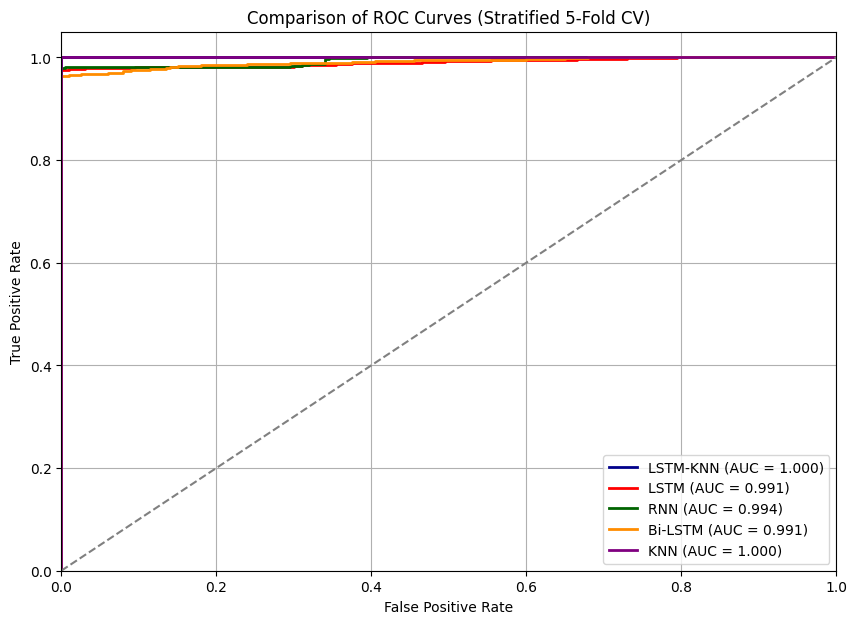

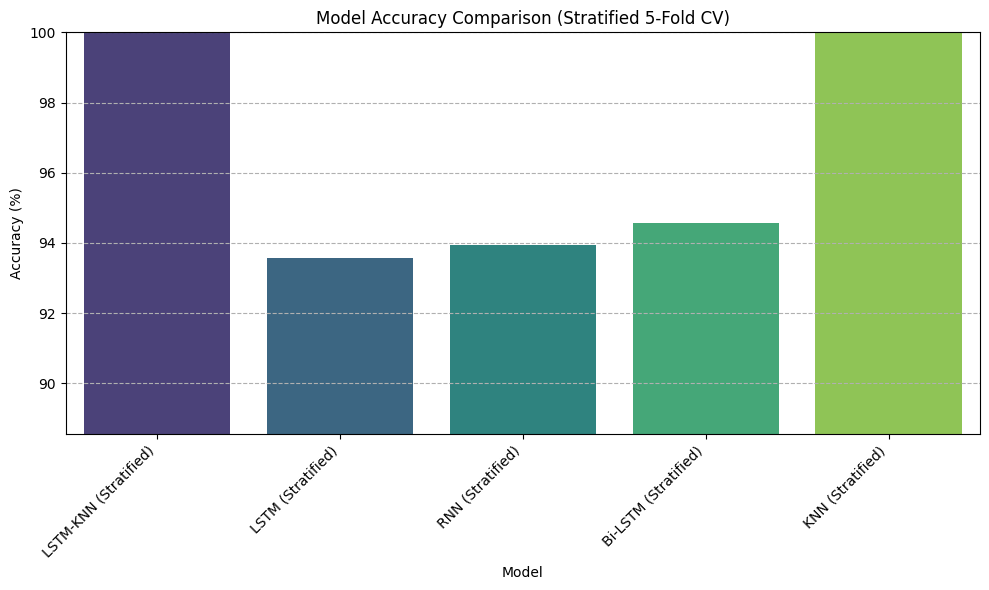

In [67]:
print("[Step 6.4] Aggregating Stratified Cross-Validation Results for All Models...")

# --- Helper function to calculate metrics for a given model ---
def calculate_metrics(y_true, y_pred_raw, model_name, fold_training_times):
    y_true = np.array(y_true)
    y_pred_raw = np.array(y_pred_raw)

    # Binarize raw predictions for classification metrics (0 or 1)
    y_pred_binary = (y_pred_raw > 0.5).astype(int)

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred_binary) * 100
    report = classification_report(y_true, y_pred_binary, target_names=['Benign', 'Attacks'], output_dict=True)
    fpr, tpr, _ = roc_curve(y_true, y_pred_raw)
    roc_auc = auc(fpr, tpr)
    avg_time = np.mean(fold_training_times)

    return {
        'Model': model_name,
        'Accuracy': acc,
        'AUC': roc_auc,
        'Benign_Precision': report['Benign']['precision'],
        'Benign_Recall': report['Benign']['recall'],
        'Benign_F1-Score': report['Benign']['f1-score'],
        'Attacks_Precision': report['Attacks']['precision'],
        'Attacks_Recall': report['Attacks']['recall'],
        'Attacks_F1-Score': report['Attacks']['f1-score'],
        'Avg_Training_Time': avg_time,
        'FPR': fpr,
        'TPR': tpr
    }

# --- Calculate metrics for each model ---
results_lstmkn_strat = calculate_metrics(all_y_true_lstmkn_strat, all_y_pred_raw_lstmkn_strat, 'LSTM-KNN (Stratified)', fold_training_times_lstmkn_strat)
results_lstm_strat = calculate_metrics(all_y_true_lstm_strat, all_y_pred_raw_lstm_strat, 'LSTM (Stratified)', fold_training_times_lstm_strat)
results_rnn_strat = calculate_metrics(all_y_true_rnn_strat, all_y_pred_raw_rnn_strat, 'RNN (Stratified)', fold_training_times_rnn_strat)
results_bilstm_strat = calculate_metrics(all_y_true_bilstm_strat, all_y_pred_raw_bilstm_strat, 'Bi-LSTM (Stratified)', fold_training_times_bilstm_strat)

# For KNN, raw predictions are directly the labels (0 or 1), so we pass them as is for binary conversion
results_knn_strat = calculate_metrics(all_y_true_knn_strat, all_y_pred_raw_knn_strat, 'KNN (Stratified)', fold_training_times_knn_strat)

# --- Combine results into a DataFrame for summary ---
summary_df_strat = pd.DataFrame([
    {
        'Model': r['Model'],
        'Accuracy': r['Accuracy'],
        'AUC': r['AUC'],
        'Benign_Precision': r['Benign_Precision'],
        'Benign_Recall': r['Benign_Recall'],
        'Benign_F1-Score': r['Benign_F1-Score'],
        'Attacks_Precision': r['Attacks_Precision'],
        'Attacks_Recall': r['Attacks_Recall'],
        'Attacks_F1-Score': r['Attacks_F1-Score'],
        'Avg_Training_Time': r['Avg_Training_Time']
    } for r in [results_lstmkn_strat, results_lstm_strat, results_rnn_strat, results_bilstm_strat, results_knn_strat]
])

print("\n--- Model Performance Summary (Stratified 5-Fold CV) ---")
print(summary_df_strat.round(4).to_markdown(index=False))

# --- Combined ROC Curve Plot ---
plt.figure(figsize=(10, 7))
plt.plot(results_lstmkn_strat['FPR'], results_lstmkn_strat['TPR'], color='darkblue', lw=2, label=f"LSTM-KNN (AUC = {results_lstmkn_strat['AUC']:.3f})")
plt.plot(results_lstm_strat['FPR'], results_lstm_strat['TPR'], color='red', lw=2, label=f"LSTM (AUC = {results_lstm_strat['AUC']:.3f})")
plt.plot(results_rnn_strat['FPR'], results_rnn_strat['TPR'], color='darkgreen', lw=2, label=f"RNN (AUC = {results_rnn_strat['AUC']:.3f})")
plt.plot(results_bilstm_strat['FPR'], results_bilstm_strat['TPR'], color='darkorange', lw=2, label=f"Bi-LSTM (AUC = {results_bilstm_strat['AUC']:.3f})")
plt.plot(results_knn_strat['FPR'], results_knn_strat['TPR'], color='purple', lw=2, label=f"KNN (AUC = {results_knn_strat['AUC']:.3f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves (Stratified 5-Fold CV)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- Accuracy Comparison Bar Chart ---
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=summary_df_strat, palette='viridis', hue='Model', legend=False)
plt.ylim(min(summary_df_strat['Accuracy']) - 5, 100) # Adjust y-lim dynamically or set a reasonable range
plt.title('Model Accuracy Comparison (Stratified 5-Fold CV)')
plt.ylabel('Accuracy (%)')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()